In [1]:
import os
from pathlib import Path
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread
import cv2
import numpy as np
import tensorflow.compat.v2 as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(os.listdir("/content/drive/MyDrive/Project/Pneumonia-Detection-on-Chest-Xrays/chest_xray"))

['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [4]:
data_dir = Path("/content/drive/MyDrive/Project/Pneumonia-Detection-on-Chest-Xrays/chest_xray/chest_xray")

In [5]:
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [6]:
train_normal_dir = train_dir / 'NORMAL'
train_pneumonia_dir = train_dir / 'PNEUMONIA'

normal_cases = train_normal_dir.glob('*jpeg')
pneumonia_cases = train_pneumonia_dir.glob('*jpeg')

train_data = []
for img in normal_cases:
    train_data.append((img, 0))
for img in pneumonia_cases:
    train_data.append((img, 1))

train_df = pd.DataFrame(train_data, columns = ['Image Path', 'Label'], index = None)
train_df = train_df.sample(frac = 1.).reset_index(drop = True)
train_df.head(10)

,Image Path,Label
0,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
1,/content/drive/MyDrive/Project/Pneumonia-Detec...,0
2,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
3,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
4,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
5,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
6,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
7,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
8,/content/drive/MyDrive/Project/Pneumonia-Detec...,1
9,/content/drive/MyDrive/Project/Pneumonia-Detec...,1


1    3875
0    1341
Name: Label, dtype: int64


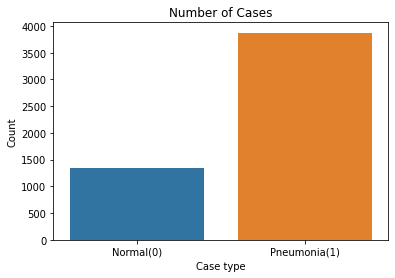

In [7]:
case_count = train_df['Label'].value_counts()
print(case_count)
plt.figure(figsize = (6, 4))
sns.barplot(x = case_count.index, y = case_count.values)
plt.title('Number of Cases')
plt.xlabel('Case type')
plt.ylabel('Count')
plt.xticks(range(len(case_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

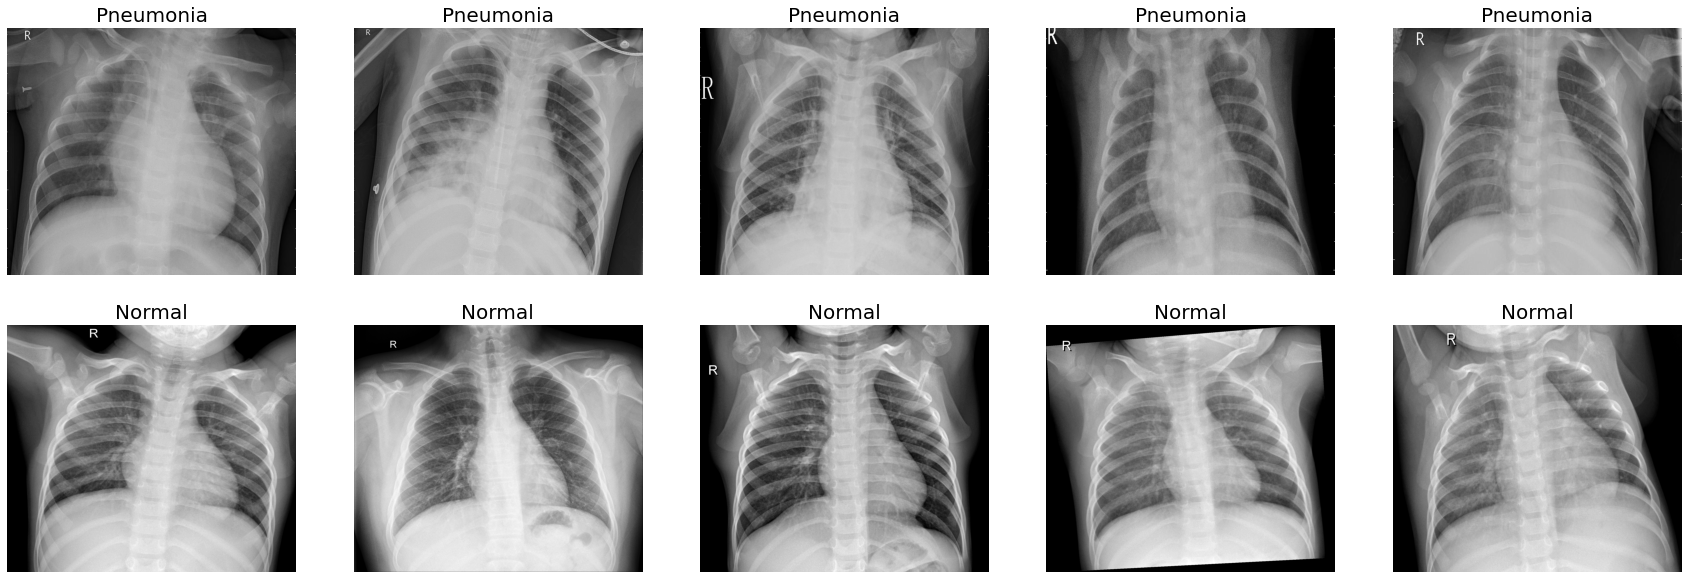

In [8]:
samples_pneumonia = (train_df[train_df['Label'] == 1]['Image Path'].iloc[:5]).tolist()
samples_normal = (train_df[train_df['Label'] == 0]['Image Path'].iloc[:5]).tolist()

total_samples = samples_pneumonia + samples_normal
del samples_pneumonia, samples_normal

f, ax = plt.subplots(2, 5, figsize=(30,10))
for i in range(0, 10):
    img = imread(total_samples[i])
    ax[i // 5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i // 5, i % 5].set_title("Pneumonia", size=20)
    else:
        ax[i // 5, i % 5].set_title("Normal", size=20)
    ax[i // 5, i % 5].axis('off')
    ax[i // 5, i % 5].set_aspect('auto')

plt.show()

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                  rotation_range=20 ,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  brightness_range=[0.6,0.9],
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator( rescale = 1.0/255)

In [10]:
# --------------------
# Flow training images in batches of 32 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(300, 300))     
# --------------------
# Flow validation images using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(val_dir,
                                                         shuffle=False,
                                                         class_mode  = 'binary',
                                                         target_size = (300, 300))

# --------------------
# Flow validation images using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         shuffle=False,
                                                         class_mode  = 'binary',
                                                         target_size = (300, 300))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

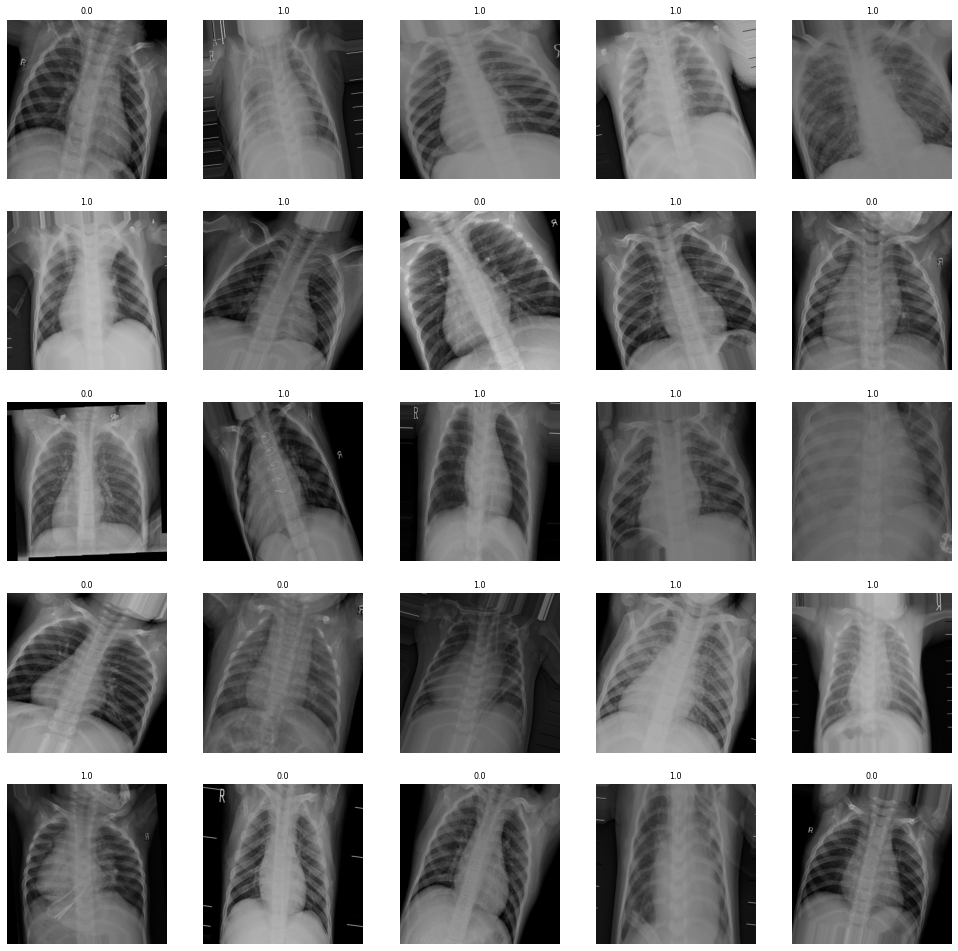

In [12]:
# viualize some images after the augmentation
x_batch, y_batch = next(train_generator)
W = 5
H = 5
fig, axes = plt.subplots(W, H, figsize = (17,17))

axes = axes.ravel() # flaten the matrix into array
for i in np.arange(0, W * H): 

    # Select a random image
    image = x_batch[i]
    # read and display an image with the selected index    
    axes[i].imshow( image )
    axes[i].set_title(y_batch[i], fontsize = 8) # the label
    axes[i].axis('off')

In [13]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

In [14]:
mobilenet_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in mobilenet_model.layers:
    layer.trainable=False
    
x = mobilenet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model3 = tf.keras.Model(inputs=mobilenet_model.input, outputs=predictions)

# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

# Compiling the model
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step


In [15]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                           

In [16]:
best_model = ModelCheckpoint('.mdl_wts.hdf5', save_best_only = True, monitor = 'val_accuracy')

In [17]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', 
                             verbose=1, 
                             monitor='val_accuracy',
                             save_best_only=True, 
                             mode='max')

In [18]:
history = model3.fit(train_generator ,epochs=30, 
                    validation_data=validation_generator,
                     steps_per_epoch=100,
                    callbacks=[checkpoint,early_stopping,lr],
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.8966
Epoch 1: val_accuracy improved from -inf to 0.81250, saving model to model-001-0.896563-0.812500.h5
100/100 [==============================] - 926s 9s/step - loss: 0.2299 - accuracy: 0.8966 - val_loss: 0.2450 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9381
Epoch 2: val_accuracy did not improve from 0.81250
100/100 [==============================] - 406s 4s/step - loss: 0.1552 - accuracy: 0.9381 - val_loss: 0.3842 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.9484
Epoch 3: val_accuracy did not improve from 0.81250
100/100 [==============================] - 219s 2s/step - loss: 0.1353 - accuracy: 0.9484 - val_loss: 0.5101 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 0.119

In [19]:
# Evaluating the model on train and test
score = model3.evaluate(train_generator)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model3.evaluate(test_generator)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 173s 1s/step - loss: 0.0728 - accuracy: 0.9732
Train Loss:  0.07277006655931473
Train Accuracy:  0.9731594920158386
20/20 [==============================] - 204s 11s/step - loss: 0.2436 - accuracy: 0.8958

Test loss:  0.24364280700683594
Test Accuracy:  0.8958333134651184


Text(0.5, 1.0, 'Accuracy Evolution')

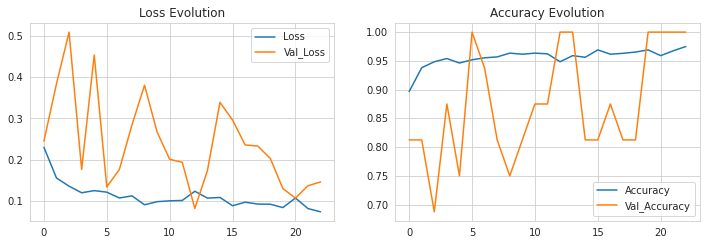

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [21]:
mobilenet_model.trainable = True

In [22]:
# how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [23]:
# Compiling the model
model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [24]:
len(model3.trainable_variables)

58

In [25]:
fine_tune_epochs = 10
epochs_on_raw_model = 30

total_epochs =  epochs_on_raw_model + fine_tune_epochs

history_fine =model3.fit(train_generator,epochs=total_epochs, 
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    callbacks=[checkpoint,early_stopping,lr],
                    batch_size=32)

Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9309
Epoch 1: val_accuracy did not improve from 1.00000
100/100 [==============================] - 112s 1s/step - loss: 0.2104 - accuracy: 0.9309 - val_loss: 8.8605 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.9594
Epoch 2: val_accuracy did not improve from 1.00000
100/100 [==============================] - 107s 1s/step - loss: 0.1094 - accuracy: 0.9594 - val_loss: 6.9341 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 0.0878 - accuracy: 0.9712
Epoch 3: val_accuracy did not improve from 1.00000
100/100 [==============================] - 106s 1s/step - loss: 0.0878 - accuracy: 0.9712 - val_loss: 3.9489 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
100/100 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9672
Epoch 4: val_accuracy did no

In [27]:
# Evaluating the model on train and test
score = model3.evaluate(train_generator)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model3.evaluate(test_generator)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

163/163 [==============================] - 174s 1s/step - loss: 0.0496 - accuracy: 0.9854
Train Loss:  0.049600210040807724
Train Accuracy:  0.9854294657707214
20/20 [==============================] - 7s 329ms/step - loss: 0.3909 - accuracy: 0.9199

Test loss:  0.39088213443756104
Test Accuracy:  0.9198718070983887


Text(0.5, 1.0, 'Accuracy Evolution')

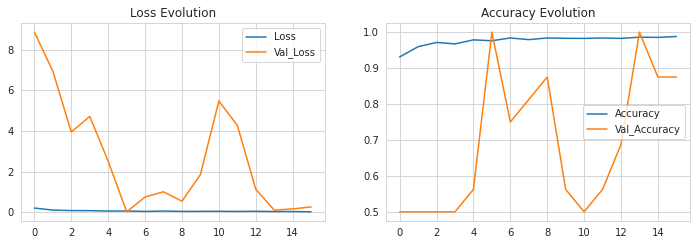

In [28]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history_fine.history['loss'], label='Loss')
plt.plot(history_fine.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history_fine.history['accuracy'], label='Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [31]:
model3.save('tuned_mobilenet.h5')

In [32]:
final_model = tf.keras.models.load_model('tuned_mobilenet.h5')

In [33]:
y_pred = final_model.predict(test_generator)

20/20 [==============================] - 8s 333ms/step


In [34]:
final_model.evaluate(test_generator)

20/20 [==============================] - 8s 327ms/step - loss: 0.3909 - accuracy: 0.9199


[0.39088213443756104, 0.9198718070983887]